In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *
import random 

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data[0],
    'X': data[1],
    'y': data[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col], random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()

In [25]:
import random

In [26]:
rng = np.random.default_rng(seed)
T.manual_seed(seed)
random.seed(seed)
reasoner = ModifiedNeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train_mod(data_tr, data_vl, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=23, batch_size=32, lr_reasoner=0.0018, lr_encoder=0.001, identities_weight=0.33, identitity_weight_decay=0.965)

head params 3283
embs params 1430
train epoch 00/23 | batch 193/192 | loss 4.1099 | val loss 0.7433 | acc 0.0946 | f1 0.1729 | prec 0.0946 | recall 1.0000 | roc auc 0.5023 | pr auc 0.1075 | elapsed 2.59s
train epoch 01/23 | batch 193/192 | loss 2.3508 | val loss 0.4812 | acc 0.7966 | f1 0.3317 | prec 0.2407 | recall 0.5337 | roc auc 0.7519 | pr auc 0.4377 | elapsed 4.72s
train epoch 02/23 | batch 193/192 | loss 1.3040 | val loss 0.3215 | acc 0.9172 | f1 0.6097 | prec 0.5500 | recall 0.6839 | roc auc 0.8828 | pr auc 0.7316 | elapsed 4.56s
train epoch 03/23 | batch 193/192 | loss 0.9083 | val loss 0.2583 | acc 0.9186 | f1 0.6295 | prec 0.5529 | recall 0.7306 | roc auc 0.9050 | pr auc 0.7708 | elapsed 4.87s
train epoch 04/23 | batch 193/192 | loss 0.6600 | val loss 0.2323 | acc 0.9172 | f1 0.6236 | prec 0.5469 | recall 0.7254 | roc auc 0.9016 | pr auc 0.7580 | elapsed 4.51s
train epoch 05/23 | batch 193/192 | loss 0.5239 | val loss 0.2348 | acc 0.9088 | f1 0.6076 | prec 0.5125 | recall 0.

             mean  std     micro
acc      0.957374  NaN  0.957374
prec     0.720833  NaN  0.720833
recall   0.896373  NaN  0.896373
f1       0.799076  NaN  0.799076
auc_roc  0.980892  NaN  0.980892
auc_pr   0.923303  NaN  0.923303


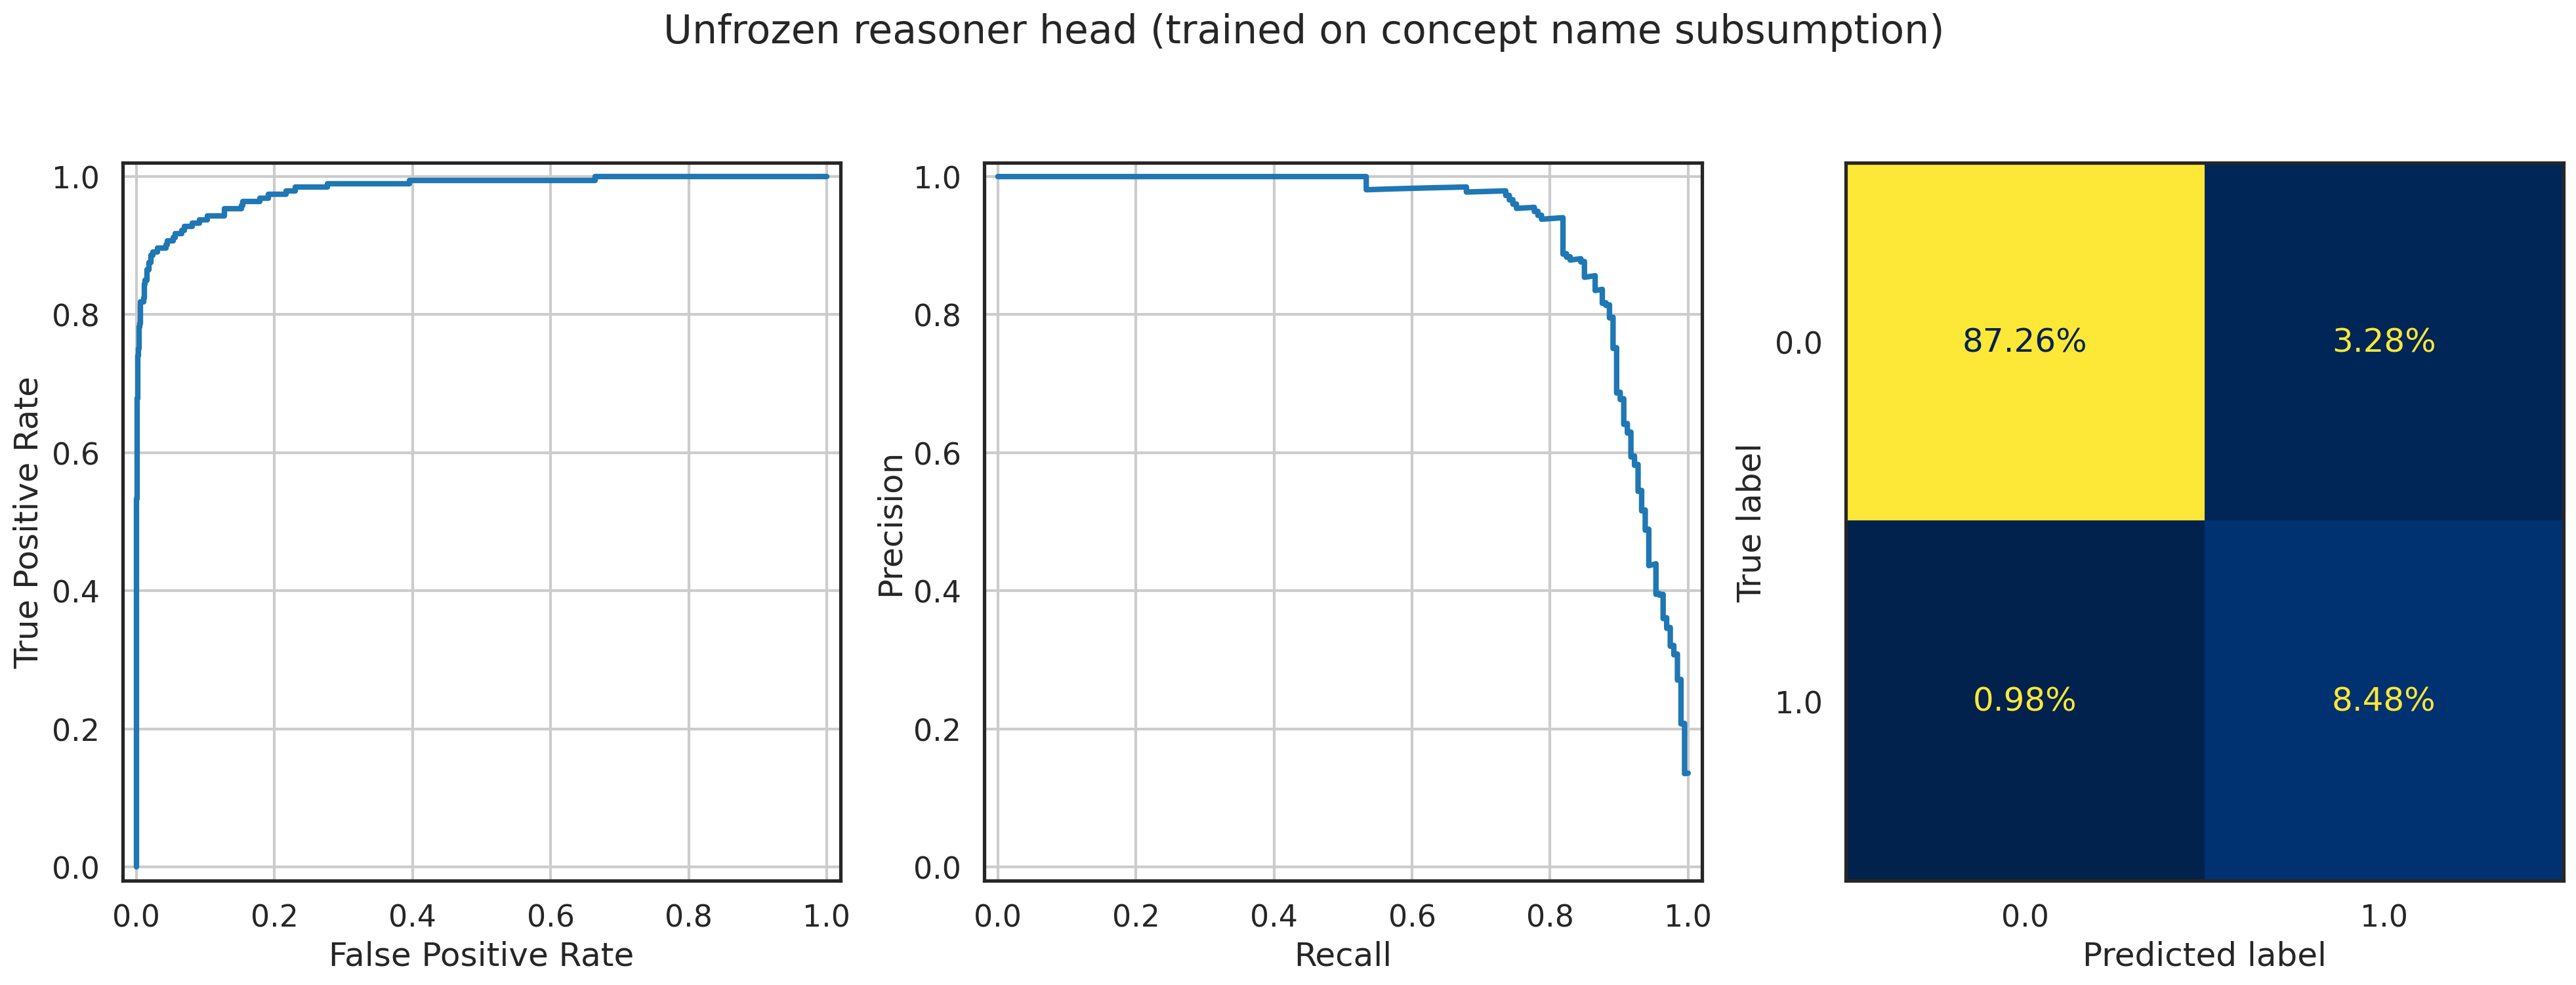

In [27]:
with T.no_grad():
    reasoner.eval()
    _, y_te, Y_te = eval_batch_mod(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_te, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

In [9]:
from random import random

input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
print(input)
print(reasoner.head.and_nn(im_mod( input, input)))
F.l1_loss(input, reasoner.head.and_nn(im_mod(input, input)))

tensor([ 0.2809,  0.0241, -0.1436,  0.0713, -0.1864, -0.1980,  0.2386, -0.2515,
        -0.1413, -0.0317], grad_fn=<SelectBackward0>)
tensor([ 0.2546,  0.0339, -0.2228,  0.0288, -0.2056, -0.1491,  0.2418, -0.2195,
        -0.1786,  0.0094], grad_fn=<AddBackward0>)


tensor(0.0340, grad_fn=<L1LossBackward0>)

In [10]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
print(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)), reasoner.head.bot_concept[0]))

tensor([ 0.2093, -0.1763,  0.1728,  0.1582,  0.1732, -0.0709, -0.2681,  0.0763,
         0.2816, -0.2304], grad_fn=<SelectBackward0>)
tensor([ 0.2148, -0.1821,  0.1791,  0.1731,  0.1654, -0.0705, -0.2808,  0.0896,
         0.2784, -0.2338], grad_fn=<AddBackward0>)
tensor(0.0073, grad_fn=<L1LossBackward0>)


In [11]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)), input))


tensor([0.3483, 0.7668, 0.1221, 0.6921, 0.1195, 0.6476, 0.4233, 0.1800, 0.7493,
        0.5020])
tensor([ 0.0354,  0.3930, -0.1881, -0.0167, -0.2056,  0.2031,  0.4227, -0.1762,
         0.1788,  0.3185], grad_fn=<AddBackward0>)
tensor(0.3586, grad_fn=<L1LossBackward0>)


In [12]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
output = reasoner.head.and_nn(im_mod(reasoner.head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.2093, -0.1763,  0.1728,  0.1582,  0.1732, -0.0709, -0.2681,  0.0763,
         0.2816, -0.2304], grad_fn=<SelectBackward0>)
tensor([ 0.2040, -0.2087,  0.1779,  0.1667,  0.1512, -0.0342, -0.2934,  0.0786,
         0.3068, -0.2297], grad_fn=<AddBackward0>)
tensor(0.2008, grad_fn=<L1LossBackward0>)


In [13]:
print(reasoner.head.bot_concept[0])
output = reasoner.head.not_nn(reasoner.head.top_concept[0])
print(output)
print(F.mse_loss(reasoner.head.bot_concept[0], output))

tensor([ 0.2093, -0.1763,  0.1728,  0.1582,  0.1732, -0.0709, -0.2681,  0.0763,
         0.2816, -0.2304], grad_fn=<SelectBackward0>)


tensor([ 0.2090, -0.1760,  0.1734,  0.1589,  0.1729, -0.0709, -0.2686,  0.0769,
         0.2816, -0.2305], grad_fn=<SqueezeBackward3>)
tensor(1.6451e-07, grad_fn=<MseLossBackward0>)


In [14]:
print(reasoner.head.top_concept[0])
output = reasoner.head.not_nn(reasoner.head.bot_concept[0])
print(output)
print(F.mse_loss(reasoner.head.top_concept[0], output))

tensor([-0.2212, -0.0830,  0.0843, -0.0805,  0.2356,  0.2508,  0.2585, -0.0503,
        -0.5483,  0.4112], grad_fn=<SelectBackward0>)
tensor([-0.2208, -0.0834,  0.0837, -0.0805,  0.2358,  0.2504,  0.2586, -0.0495,
        -0.5480,  0.4114], grad_fn=<SqueezeBackward3>)
tensor(1.6395e-07, grad_fn=<MseLossBackward0>)


In [15]:
input1 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
input2 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.and_nn(im_mod(input2,input1)))
print(reasoner.head.and_nn(im_mod(input1,input2)))

F.mse_loss(reasoner.head.and_nn(im_mod(input2,input1)) , reasoner.head.and_nn(im_mod(input1,input2)))

tensor([ 0.0440,  0.0226,  0.1370, -0.0020,  0.0558,  0.1071, -0.0847,  0.0835,
         0.3245, -0.1498], grad_fn=<AddBackward0>)
tensor([ 0.0475,  0.0238,  0.1408, -0.0006,  0.0588,  0.1055, -0.0805,  0.0853,
         0.3289, -0.1489], grad_fn=<AddBackward0>)


tensor(8.4169e-06, grad_fn=<MseLossBackward0>)

In [16]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.5

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te_2))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te_2[błędne_predykcje],
    'Predykcja': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

print(wyniki)

     Rekord  Prawdziwa Etykieta  Predykcja  Feature_0  Feature_1  Feature_2
0         2                 1.0   0.001212          0         77         41
1         7                 0.0   0.864205          0          4         90
2        13                 0.0   0.992967          0         70         59
3        23                 0.0   0.868146          0         65         63
4        55                 0.0   0.997805          0         54         48
..      ...                 ...        ...        ...        ...        ...
96     1977                 0.0   0.816729          0         76         60
97     1985                 1.0   0.094972          0         27         97
98     2005                 0.0   0.560694          0         54         49
99     2008                 0.0   0.968344          0         84         28
100    2020                 0.0   0.713736          0          0         78

[101 rows x 6 columns]


In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wyniki)

     Rekord  Prawdziwa Etykieta  Predykcja  Feature_0  Feature_1  Feature_2
0         2                 1.0   0.001212          0         77         41
1         7                 0.0   0.864205          0          4         90
2        13                 0.0   0.992967          0         70         59
3        23                 0.0   0.868146          0         65         63
4        55                 0.0   0.997805          0         54         48
5        60                 0.0   0.738928          0         66         90
6        89                 1.0   0.001466          0         29         40
7       124                 0.0   0.945826          0          3         10
8       127                 0.0   0.657804          0          8         21
9       144                 0.0   0.931621          0         37         35
10      223                 1.0   0.026272          0          0         11
11      244                 0.0   0.545194          0         14         76
12      297 

In [18]:

print(T.round( T.matmul( reasoner.head.not_nn.weight,reasoner.head.not_nn.weight) *100)/100)

tensor([[1., 0., 0., 0., -0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., -0., -0., -0., -0., -0., -0.],
        [0., 0., 1., -0., -0., 0., 0., 0., -0., 0.],
        [-0., -0., -0., 1., 0., -0., -0., 0., 0., 0.],
        [0., -0., 0., 0., 1., 0., -0., -0., -0., -0.],
        [0., -0., 0., 0., -0., 1., -0., 0., -0., 0.],
        [0., -0., -0., 0., -0., -0., 1., 0., -0., 0.],
        [0., -0., 0., -0., -0., 0., -0., 1., -0., -0.],
        [-0., 0., 0., 0., 0., -0., 0., 0., 1., -0.],
        [-0., -0., -0., -0., 0., -0., -0., -0., -0., 1.]],
       grad_fn=<DivBackward0>)
